## Import packages and initial DataFrame

In [10]:
import pandas as pds
import numpy as np
import textdistance
import statsmodels.api as sm
import scipy
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt
import scipy.interpolate as interpolate

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

aaa = 5.5
bbb = 0.01
ccc = 0.08
ddd = 0.7

identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

def levenshtein_similarity(a,b):
    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        a: string,
        b: string """
    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):
    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        a: string,
        b: string """
    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):
    """ Check that a and b values are equal.
        a: any value,
        b: any value """
    return a==b

def large_equality(a,b):
    """ Check that years a and b expressed with four numbers are within the same decade.
        a: year,
        b: year """
    return str(a)[:-1]==str(b)[:-1]

def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

def inverse_transform_sampling(data, n_bins):
    n_samples = 1
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In [11]:
nbr_iter = 800
approx_integral = 50
a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
nbr_in_common = 100

dict_params_legend = {
    "unmatch":identifiers.keys(), 
    "match":identifiers.keys(), 
    "sigma_square":[f"$\sigma^2$"], 
    "betas":[ r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\beta_5$", r"$\beta_6$", r"$\beta_7$" ], 
    "sigma2_square":[r"$\sigma_2^2$"], 
    "mu2":[r"$\mu_2$"], 
    "atel":["atel"]}

dict_params_title = {
    "unmatch":"unmatch", 
    "match":"match", 
    "sigma_square":r"$\sigma^2$", 
    "betas":r"$\beta$",
    "sigma2_square":r"$\sigma_2^2$", 
    "mu2":r"$\mu_2$", 
    "atel":"atel"}

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

ate = aaa * 2.5

In [12]:
DF = DF.sample(n = nbr_in_common + 250 + 430)

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(-0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4**2 +0.5*DF.X5) ))

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])

DF['Y'] = - 10 + aaa*DF['treatment']*DF['X2'] + bbb*np.exp(DF['X4']) + ccc*DF['X3']*DF['X1'] + ddd*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

common_records = DF.iloc[:nbr_in_common, :].copy()

ate_common_records = aaa * common_records['X2'].mean()

B = pds.concat([DF.iloc[nbr_in_common:nbr_in_common+250, :].copy(), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.iloc[nbr_in_common+250:, :].copy(), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

# delete some data --> typos
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id1'] = ''
A.loc[np.random.choice(np.arange(A.shape[0]), size=5), 'id3'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id2'] = ''

B['propensity_score'] = propensity_score(B, covariates, None, False)

cartesian_product_AB = B.merge(A, how='cross', suffixes=("_B", "_A"))
cartesian_product_AB["source_index_B"] = np.repeat(B.index, A.shape[0])
cartesian_product_AB["source_index_A"] = np.tile(A.index, B.shape[0])

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = cartesian_product_AB.filter(regex=linking_var)
    cartesian_product_AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors = cartesian_product_AB.filter(regex="comparison")

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-nbr_in_common:,:].index] = A.iloc[-nbr_in_common:,:].index

intercept = np.ones(cartesian_product_AB.shape[0])
records_treatment =  np.array(cartesian_product_AB.treatment)
records_propensity_score = np.array(cartesian_product_AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
records_covariates = np.array(cartesian_product_AB[covariates])
X = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

records_treatment_miss =  1 - np.array(cartesian_product_AB.treatment)
interaction_term_miss = records_treatment_miss * records_propensity_score
X_miss = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term_miss.reshape(-1,1)], axis=1)

new_z = -np.ones(B.shape[0])
new_z[::2] = np.arange(len(new_z[::2]))

n_A = A.shape[0]
n_B = B.shape[0]

idx_match_A = new_z[new_z>=0]
idx_match_B = np.nonzero(new_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])
dict_empirical_count_linkage = {pair:0 for pair in pairs}
dict_params = {"unmatch":[], "match":[], "sigma_square":[], "betas":[], "sigma2_square":[], "mu2":[], "atel":[]}

Betas = scipy.stats.multivariate_normal.rvs(np.zeros(X.shape[1]), np.eye(X.shape[1]))
mu2 = scipy.stats.norm.rvs(0, 1)

dev = 0.25 * np.std(cartesian_product_AB.Y)
low_val = int(np.min(cartesian_product_AB.Y) - dev)
high_val = int(np.max(cartesian_product_AB.Y) + dev)
nbr_pts = int(high_val - low_val)

In [13]:
for _ in tqdm.tqdm(range(nbr_iter)):

    ### --  UPDATE THETA --> match, unmatch
    comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    unmatch = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)
    comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    match = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)
    dict_params["unmatch"].append(unmatch)
    dict_params["match"].append(match)

    ### --  UPDATE COEF OUTCOME MODEL (MATCHES AND NON MATCHES) --> Betas --> mu2, sigma2_square --> outcome model distribution
    data_for_matches = cartesian_product_AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    intercept = np.ones(len(outcome_for_matches))
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = np.array(data_for_matches.propensity_score)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    linked_records_covariates = np.array(data_for_matches[covariates])
    K = np.concatenate([intercept.reshape(-1,1), linked_records_covariates, linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(new_z>=0)
    sigma_square = scipy.stats.invgamma.rvs(a_sigma + n_AB/2, loc=0, scale=np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma)
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(K.shape[1]) )
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    dict_params["sigma_square"].append(sigma_square)
    dict_params["betas"].append(Betas)

    data_for_non_matches = A[~A.index.isin(idx_match_A)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    sigma2_square = scipy.stats.invgamma.rvs(a_sigma2 + (n_A - n_AB)/2, loc=0, scale=b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2)
    sigma_mu2_square = 1 / ((n_A - n_AB)/sigma2_square + 1)
    m_mu2 = sigma_mu2_square * ((outcome_for_non_matches).sum() / sigma2_square)
    mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, mu2, np.sqrt(sigma2_square))
    dict_params["sigma2_square"].append(sigma2_square)
    dict_params["mu2"].append(mu2)
    
    ### --  UPDATE PROBABILITIES
    w1 = ( np.multiply( comparison_vectors, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(n_B, n_A)
    
    for j in range(n_B):
        n_AB_ = (np.delete(new_z, j)>=0).sum()
        proba_for_unmatch = (n_A - n_AB_) * (n_B - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
        not_possible_values = list( set(np.delete(new_z, j).astype(int)) - set([-1]) )
        proba = probabilities[j,:].copy()
        proba[not_possible_values]  = 0
        proba = np.append(proba, proba_for_unmatch)
        possible_values = np.arange(n_A)
        possible_values = np.append(possible_values, -1)
        val = choices(possible_values, weights = proba)[0]
        new_z[j] = val

    ### ATEL
    y_miss_new = np.random.uniform( low_val, high_val, size = (data_for_matches.shape[0], nbr_pts)) # generate a y_miss vector (of nbr_pts) for each individual
    X_miss_new = X_miss[pairs.isin(links)] # get 1 X vector for each individual 
    Betas_miss_new = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=(nbr_pts, approx_integral)) # generate approx_integral Betas vectors for each point
    y_miss_new = np.repeat(y_miss_new[:, np.newaxis, :], approx_integral, axis=1)
    ITS = np.mean( y_miss_new - ( Betas_miss_new @ X_miss_new.T ).T, axis = 1)
    missing_outcomes_new = np.array([ inverse_transform_sampling(ITS[indiv], len(ITS[indiv])) for indiv in range(ITS.shape[0]) ])
    new_Y0 = (data_for_matches.treatment==0) * data_for_matches.Y + (data_for_matches.treatment==1) * missing_outcomes_new.flatten()
    new_Y1 = (data_for_matches.treatment==1) * data_for_matches.Y + (data_for_matches.treatment==0) * missing_outcomes_new.flatten()
    new_atel = np.mean(new_Y1 - new_Y0)
    dict_params["atel"].append(new_atel)

    ### _ UPDATE INDICES FOR MATCHES
    idx_match_A = new_z[new_z>=0]
    idx_match_B = np.nonzero(new_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))

    for link in links: # check burn-in
        dict_empirical_count_linkage[link] += 1

v = np.array(list(dict_empirical_count_linkage.values())) / nbr_iter
k = np.array(list(dict_empirical_count_linkage.keys()))

100%|██████████| 800/800 [01:44<00:00,  7.62it/s]


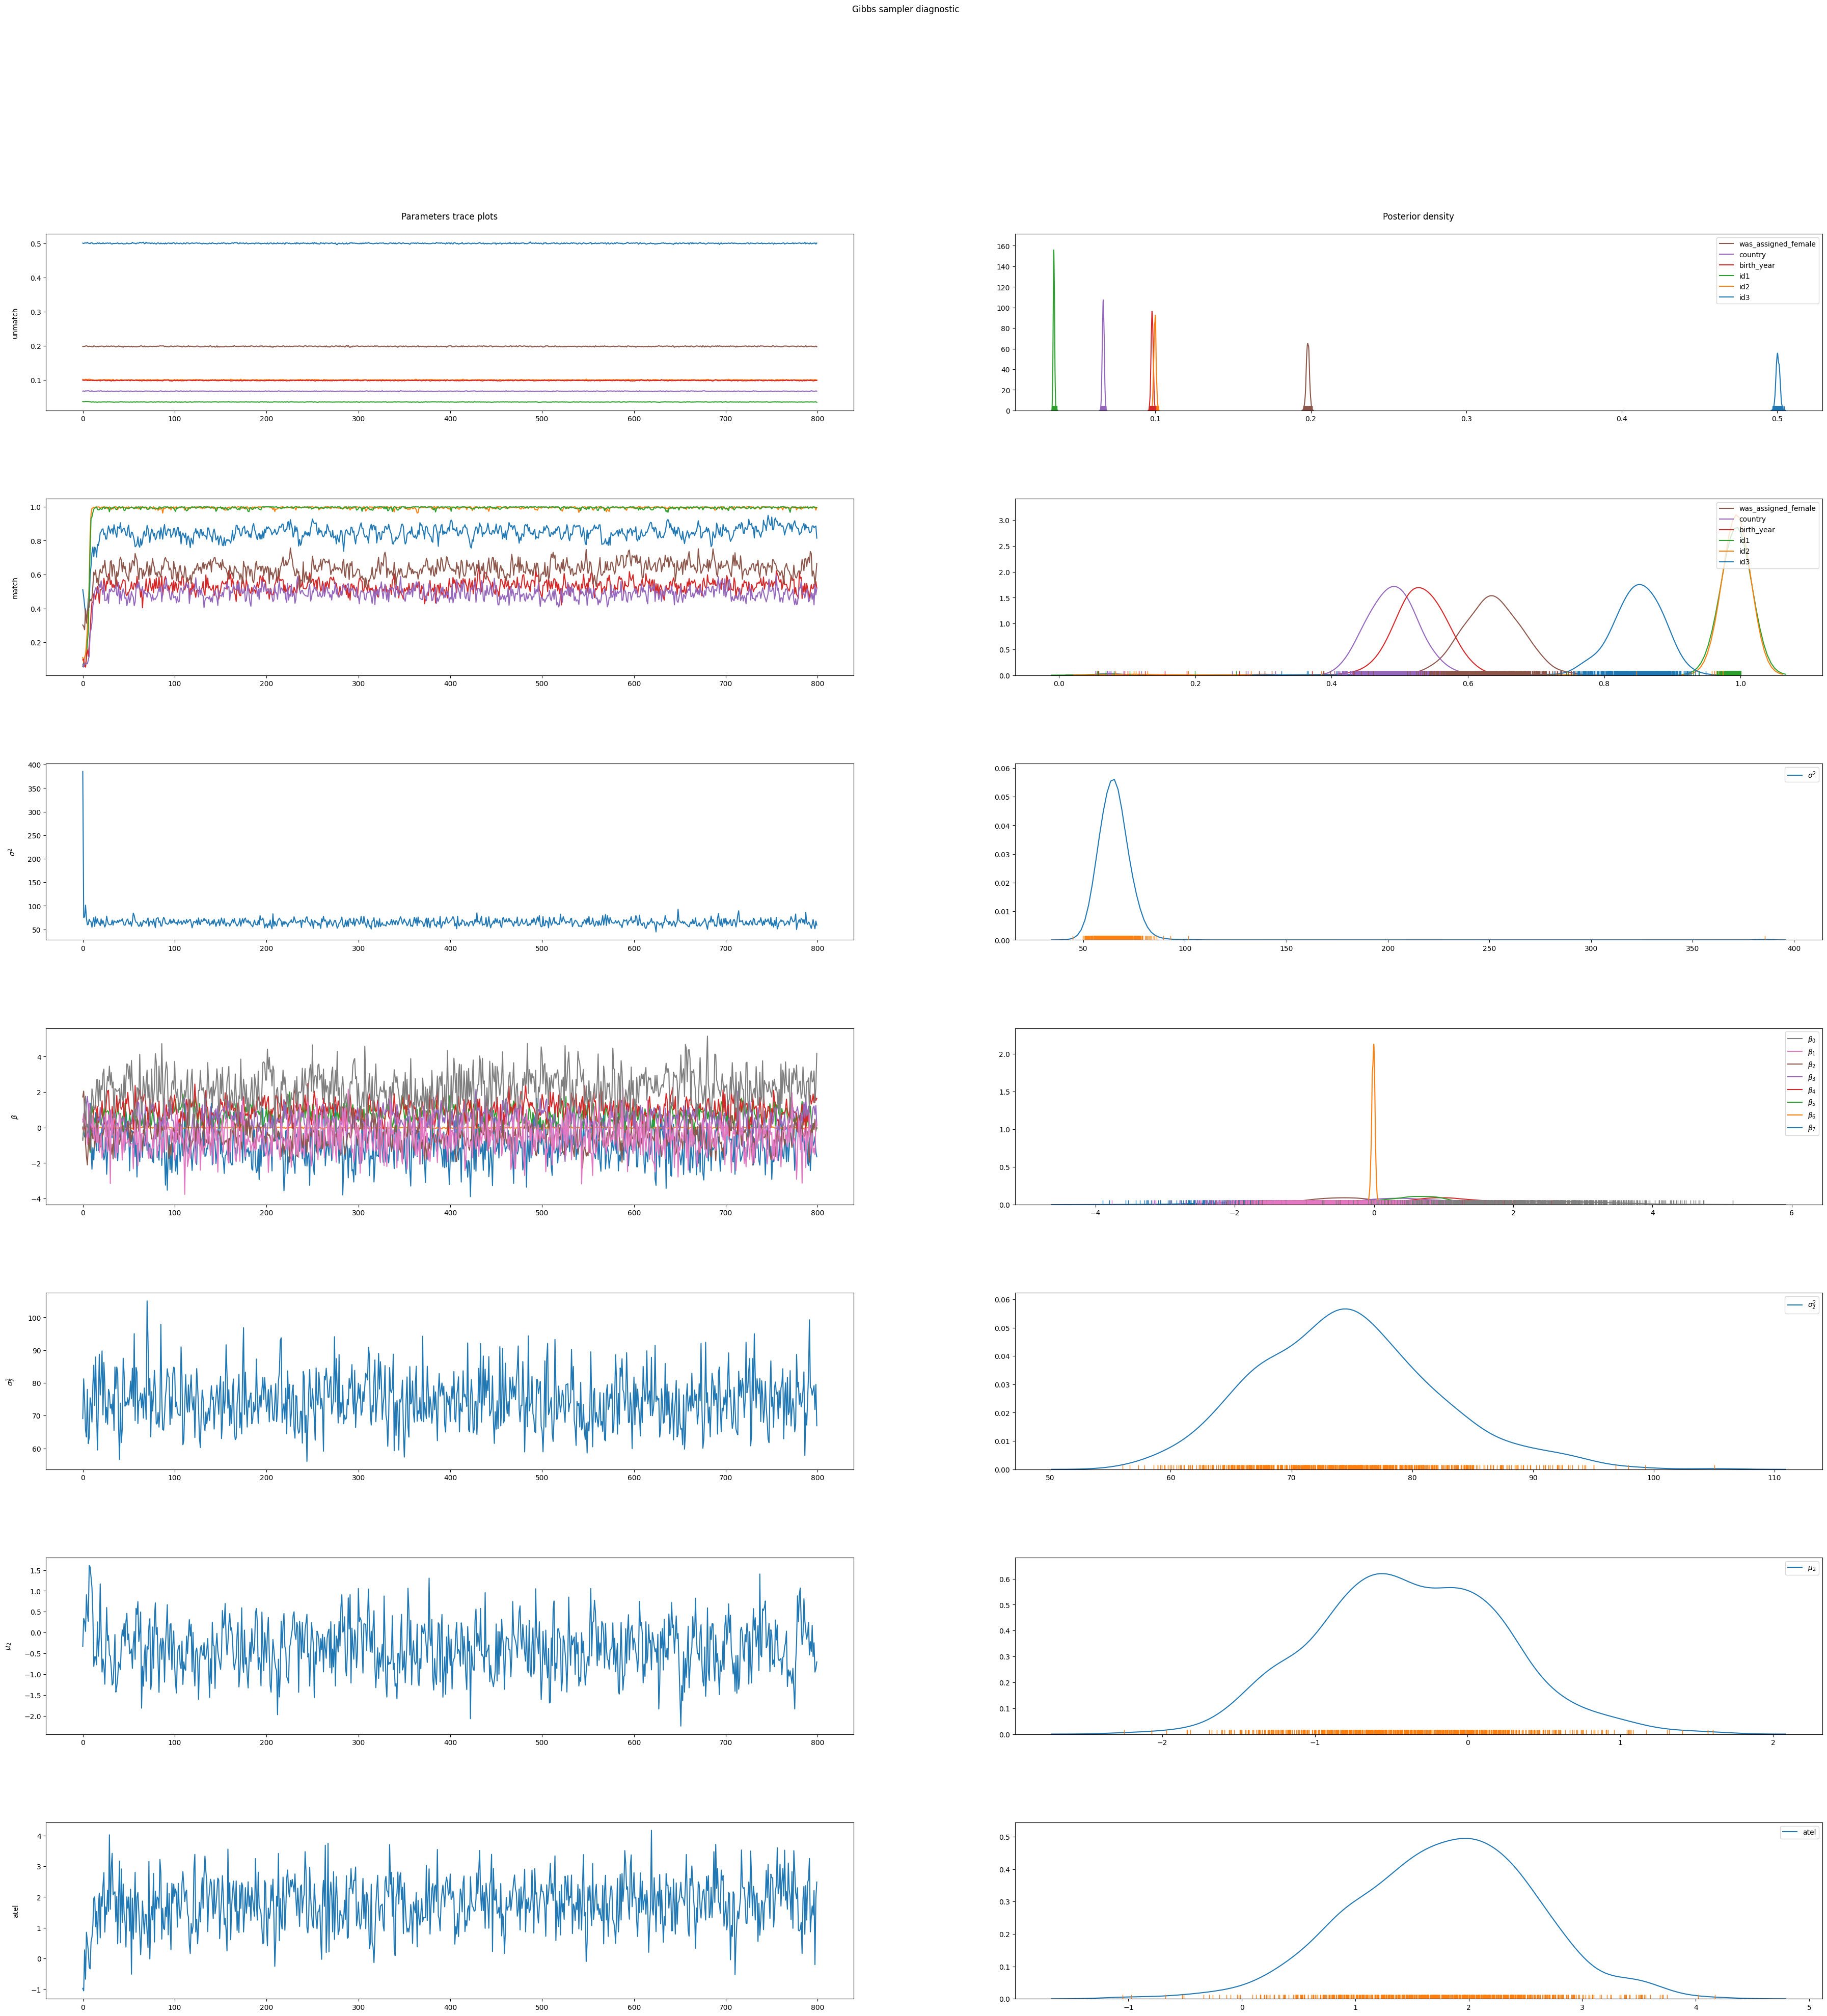

In [14]:
plt.figure(figsize = (45, 45))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Gibbs sampler diagnostic")
i=0
for n, param in enumerate(dict_params.keys()):
    i+=1
    ax1 = plt.subplot(7, 2, n + i) # row, column, number on which current drawing
    ax1.plot(dict_params[param])
    if n==0:
        ax1.set_title("Parameters trace plots\n")
    ax1.set_xlabel("")
    ax1.set_ylabel(f"{dict_params_title[param]}\n")

    j=i+1
    ax2 = plt.subplot(7, 2, n + j) 
    sns.kdeplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    sns.rugplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    if n==0:
        ax2.set_title("Posterior density\n")
    ax2.legend(dict_params_legend[param], loc='upper right')
    ax2.set_xlabel("")
    ax2.set_ylabel("")
plt.savefig(os.path.join('img', f"gibbs_sampler_diagnostic.pdf"), format="pdf", bbox_inches="tight")
plt.show()

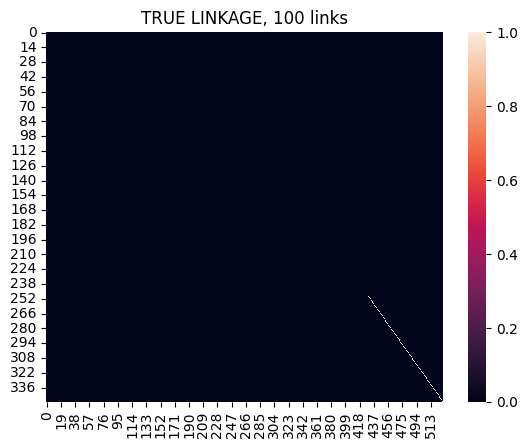

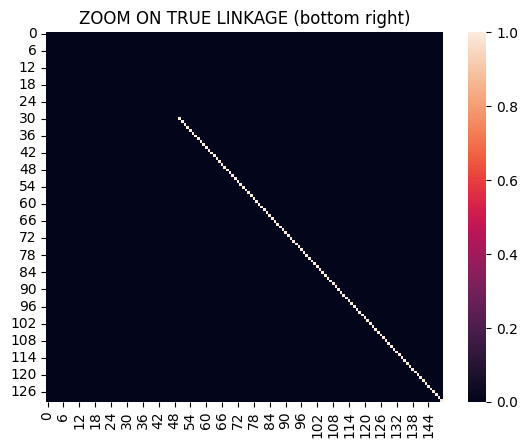

In [15]:
z_linkage_vector = true_linkage_z.copy()

idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

sns.heatmap(linkage_matrix)
plt.title(f"TRUE LINKAGE, {(linkage_matrix==1).sum()} links")
plt.savefig(os.path.join('img', f"true_linkage_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[220:, 380:])
plt.title(f"ZOOM ON TRUE LINKAGE (bottom right)")
plt.savefig(os.path.join('img', f"zoom_true_linkage_(bottom-right).pdf"), format="pdf", bbox_inches="tight")
plt.show()

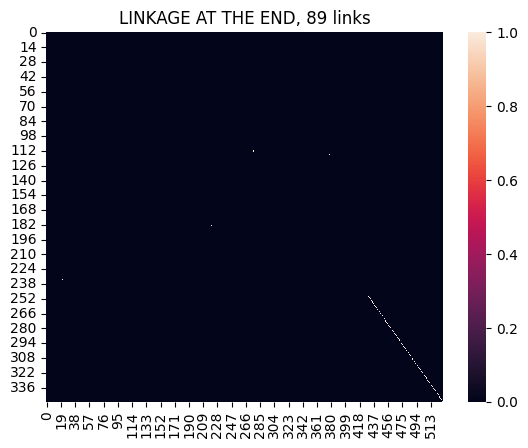

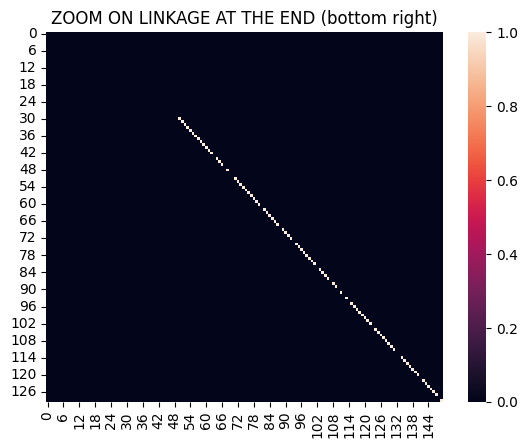

In [16]:
best = k[v>=0.9]
idx_A = best[:,0]
idx_B = best[:,1]

linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_A)):
    A_idx = idx_A[link]
    B_idx = idx_B[link]
    linkage_matrix[B_idx, A_idx] = 1

sns.heatmap(linkage_matrix)
plt.title(f"LINKAGE AT THE END, {(linkage_matrix==1).sum()} links")
plt.savefig(os.path.join('img', f"linkage_at_end_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[220:, 380:])
plt.title(f"ZOOM ON LINKAGE AT THE END (bottom right)")
plt.savefig(os.path.join('img', f"linkage_at_end_(bottom-right).pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [17]:
ate_common_records

14.704047505330962

In [18]:
links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
data_for_matches = cartesian_product_AB[pairs.isin(links)]
    
### ATEL
y_miss_new = np.random.uniform( low_val, high_val, size = (data_for_matches.shape[0], nbr_pts)) # generate a y_miss vector (of nbr_pts) for each individual
X_miss_new = X_miss[pairs.isin(links)] # get 1 X vector for each individual 
Betas_miss_new = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=(nbr_pts, approx_integral)) # generate approx_integral Betas vectors for each point
y_miss_new = np.repeat(y_miss_new[:, np.newaxis, :], approx_integral, axis=1)
ITS = np.mean( y_miss_new - ( Betas_miss_new @ X_miss_new.T ).T, axis = 1)
missing_outcomes_new = np.array([ inverse_transform_sampling(ITS[indiv], len(ITS[indiv])) for indiv in range(ITS.shape[0]) ])
new_Y0 = (data_for_matches.treatment==0) * data_for_matches.Y + (data_for_matches.treatment==1) * missing_outcomes_new.flatten()
new_Y1 = (data_for_matches.treatment==1) * data_for_matches.Y + (data_for_matches.treatment==0) * missing_outcomes_new.flatten()
new_atel = np.mean(new_Y1 - new_Y0)
new_atel

6.875533470357934